## Gradient boosting from scratch


In [0]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import tree
from scipy import optimize

import matplotlib.pyplot as plt
%matplotlib inline

Let's generate a toy dataset for classification.

In [0]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, shuffle=True, noise=0.15, random_state=1011)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1011)

## Gradient Boosting Classifier

In [0]:
class GradientBoostingClf(BaseEstimator, ClassifierMixin):
    def sigma(self, z):
      z = z.reshape([z.shape[0], 1])
      z[z > 100] = 100
      z[z < -100] = -100
      return 1. / (1 + np.exp(-z))

    def logloss(self, y, p):
      return metrics.log_loss(y, p, normalize=False)

    def dlogloss(self, y, p):
      y = y.reshape([y.shape[0], 1])
      p = p.reshape([p.shape[0], 1])
      p[p < 1e-5] = 1e-5
      p[p > 1 - 1e-5] = 1 - 1e-5
      return (p - y) / p / (1 - p)

             
    def __init__(self, N_estimators = 10, max_depth = 2, learning_rate = 0.01, random_state=1337, debug=False):
        self.N_estimators = N_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.learning_rate = learning_rate
        self.models = []
        self.grad_loss = self.dlogloss
        self.loss = self.logloss
        self.debug = debug

    def fit(self, X, y):
        self.X = X
        self.y = y
        #initialize with starting values (all means)
        y_i = np.mean(y) * np.ones([y.shape[0], 1]) 
        preds = y_i.copy()
        #iteratively build estimators
        for t in range(self.N_estimators):
          #compute residual from previous prediction (anti gradient)
          
          resid = - self.grad_loss(y, preds)
          #print ('Residuals on {} iter: {}'.format(t, resid))

          #fit estimator (regression tree) on residuals & predict
          regr_tree = tree.DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
          regr_tree.fit(X, resid)
          y_i = regr_tree.predict(X).reshape([X.shape[0], 1])
          #print ('Predict on {} iter: {}'.format(t, y_i))
          
          #save model
          self.models.append(regr_tree)
          preds += self.learning_rate * y_i
          #compute loss to see progress
          if self.debug == True:
            print ('Loss on {} iter: {}'.format(t, self.loss(y, preds)))
        #save train predictions
        self.train_pred = preds
        self.train_pred = self.sigma(self.train_pred)
        return self

    def predict_proba(self, X):
        #initialize with starting values (all means)
        preds = np.mean(y) * np.ones([X.shape[0], 1])
        #iteratively add predicts of every model from train phase
        for t in range(self.N_estimators):
          preds += preds * self.models[t].predict(X).reshape([X.shape[0], 1])
        return self.sigma(preds)
        #return preds
    
    def predict(self, X):
      pred_probs = self.predict_proba(X)
      max_accuracy = 0 
      best_thres = 0
      for thres in np.linspace(0.01, 1.01, 100):
          acc = metrics.accuracy_score(self.y, self.train_pred > thres)
          if acc > max_accuracy:
              max_accuracy = acc
              best_thres = thres
      print ('Best threshold:', best_thres)
      return pred_probs > best_thres

# clf = GradientBoostingClf()
# clf.fit(X_train, y_train)
# clf.predict_proba(X_test)

### Cross validate to get accuracy score

In [0]:
clf = GradientBoostingClf(N_estimators=20, learning_rate=0.05, max_depth=3, debug=True) #N_estimators=30, learning_rate=0.01
scores = cross_val_score(clf, X, y, scoring='accuracy', error_score = 'raise')
print (scores, 'Mean:', np.mean(scores))

Loss on 0 iter: 219.28120536822328
Loss on 1 iter: 177.5919951320061
Loss on 2 iter: 145.52635829023023
Loss on 3 iter: 118.21085257151658
Loss on 4 iter: 95.3457502090602
Loss on 5 iter: 75.06210226402382
Loss on 6 iter: 57.48468812154536
Loss on 7 iter: 43.41266157523591
Loss on 8 iter: 35.887375962631054
Loss on 9 iter: 31.07842574892799
Loss on 10 iter: 27.42379544411449
Loss on 11 iter: 24.417013972135923
Loss on 12 iter: 22.22758689946444
Loss on 13 iter: 20.31557278715243
Loss on 14 iter: 20.55156213242116
Loss on 15 iter: 20.622210552447072
Loss on 16 iter: 20.7168561516648
Loss on 17 iter: 19.12963426761292
Loss on 18 iter: 19.178229896194864
Loss on 19 iter: 19.27025752355899
Best threshold: 0.6362626262626263
Loss on 0 iter: 222.23933830678834
Loss on 1 iter: 182.6395782011282
Loss on 2 iter: 151.2687132027449
Loss on 3 iter: 125.90137511737831
Loss on 4 iter: 103.67204216645301
Loss on 5 iter: 83.75437456132457
Loss on 6 iter: 67.50422029314696
Loss on 7 iter: 52.6220864873

## Decision Regions Plot

Loss on 0 iter: 163.64784958803085
Loss on 1 iter: 132.80478316434917
Loss on 2 iter: 108.36908242995489
Loss on 3 iter: 88.43244704698576
Loss on 4 iter: 72.05292692487397
Loss on 5 iter: 57.41642349208384
Loss on 6 iter: 43.967112536370244
Loss on 7 iter: 37.06043608565426
Loss on 8 iter: 28.60896339942115
Loss on 9 iter: 25.963707835122996
Loss on 10 iter: 23.945329791844877
Loss on 11 iter: 22.70830402087987
Loss on 12 iter: 22.73264496176192
Loss on 13 iter: 22.92646232962808
Loss on 14 iter: 19.77404687012149
Loss on 15 iter: 19.858884000833726
Loss on 16 iter: 20.029106005075175
Loss on 17 iter: 20.06249627607835
Loss on 18 iter: 20.227783318721198
Loss on 19 iter: 20.38861061724917
Best threshold: 0.6665656565656566


/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


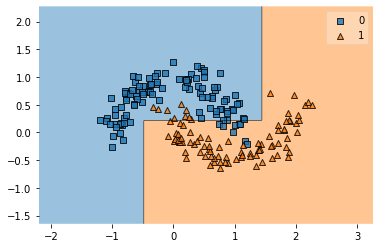

In [0]:
from mlxtend.plotting import plot_decision_regions
# 0 means 1 due to issue in mlextend
clf.fit(X_train, y_train)
plot_decision_regions(X_test, y_test, clf=clf)
plt.show()